# Step 1: Import Libraries

In [1]:
from __future__ import print_function
%matplotlib inline
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import pandas as pd
import pandas_profiling
from pandas_profiling import ProfileReport
plt.style.use("ggplot")
warnings.simplefilter("ignore")

In [2]:
plt.rcParams['figure.figsize'] = (12,8)

# Step 2: Load Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#store data in pandas data frame
hr = pd.read_csv("/content/drive/My Drive/Data Science/Data Sets/Predict Employee Turnover/employee_data.csv")

# Step 3: Exploratory Data Analysis

In [5]:
hr.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary
0,0.43,0.47,2,144,3,0,1,0,hr,medium
1,0.09,0.85,6,289,4,0,1,0,hr,high
2,0.43,0.52,2,160,3,0,1,0,technical,low
3,0.90,0.96,4,258,5,0,1,0,technical,medium
4,0.84,1.00,5,234,5,0,1,0,technical,medium


In [7]:
#! pip install pandas-profiling==2.8.0

data_report = pandas_profiling.ProfileReport(hr, title="HR Data Report")

data_report

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

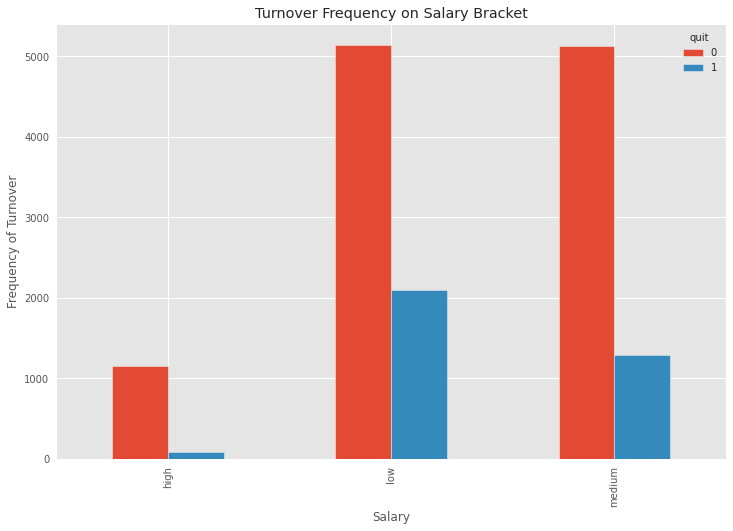

In [ ]:
pd.crosstab(hr.salary, hr.quit).plot(kind='bar')
plt.title("Turnover Frequency on Salary Bracket")
plt.xlabel('Salary')
plt.ylabel('Frequency of Turnover')
plt.show()

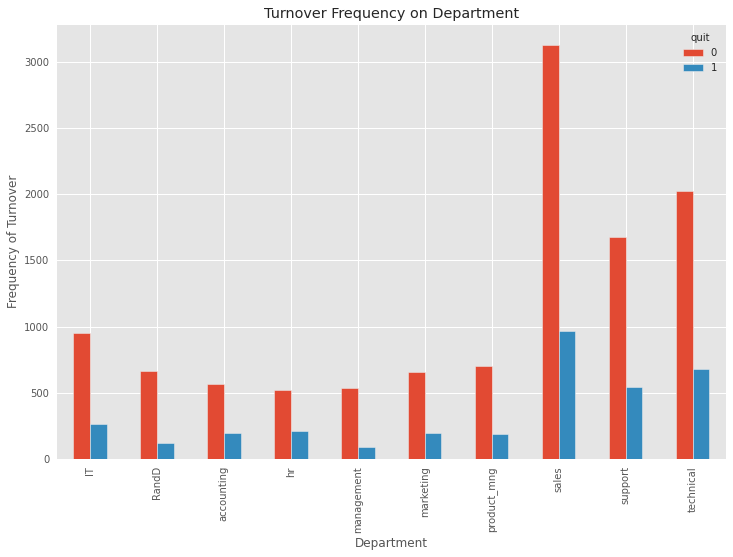

In [ ]:
pd.crosstab(hr.department, hr.quit).plot(kind='bar')
plt.title("Turnover Frequency on Department")
plt.xlabel('Department')
plt.ylabel('Frequency of Turnover')
plt.show()

# Step 4: Encode Categorical Features

In [ ]:
cat_vars = ['department', 'salary']

for var in cat_vars:
    cat_list = pd.get_dummies(hr[var], prefix=var)
    hr = hr.join(cat_list)

In [ ]:
hr.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
0,0.43,0.47,2,144,3,0,1,0,hr,medium,0,0,0,1,0,0,0,0,0,0,0,0,1
1,0.09,0.85,6,289,4,0,1,0,hr,high,0,0,0,1,0,0,0,0,0,0,1,0,0
2,0.43,0.52,2,160,3,0,1,0,technical,low,0,0,0,0,0,0,0,0,0,1,0,1,0
3,0.90,0.96,4,258,5,0,1,0,technical,medium,0,0,0,0,0,0,0,0,0,1,0,0,1
4,0.84,1.00,5,234,5,0,1,0,technical,medium,0,0,0,0,0,0,0,0,0,1,0,0,1


In [ ]:
hr.drop(columns=['department', 'salary'], axis=1, inplace=True)

# Step 5: Visualize Class Imbalance

In [ ]:
from yellowbrick.target import ClassBalance
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12,8)

ClassBalance(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f636a213320>,
             colormap=None, colors=None, labels=['stayed', 'quit'])

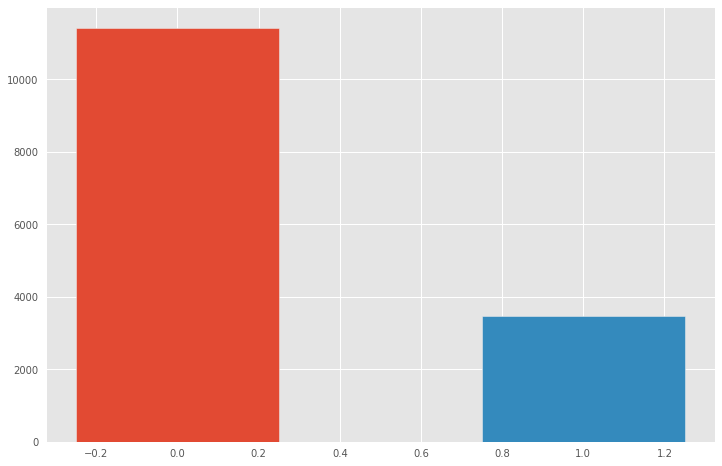

In [ ]:
visualizer = ClassBalance(labels=['stayed', 'quit']).fit(hr.quit)
visualizer

# Step 6: Create Training and Test Sets

In [ ]:
X = hr.loc[:, hr.columns != 'quit']
y = hr.quit

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2, stratify=y)

# Step 7: Build an Interactive Decision Tree Classifier

Supervised learning: 
- The inputs are random variables $X = X_1, ..., X_p$;
- The output is a random variable $Y.$

- Data is a finite set $$\mathbb{L}=\{(x_i,y_i)|i=0, ..., N-1\}$$
where $x_i \in X = X_1 \times ... \times X_p$ and $y_i \in y$ are randomly drawn from $P_{X,Y}.$

E.g., $(x_i,y_i)=((\text{salary = low, department = sales, ...}),\text{quit = 1})$

- The goal is to find a model $\varphi_\mathbb{L}: X \mapsto y$ minimizing $$\text{Err}(\varphi_\mathbb{L}) = \mathbb{E}_{X,Y}\{L(Y, \varphi_\mathbb{L}(X))\}.$$

About:
 
 - Decision trees are non-parametric models which can model arbitrarily complex relations between inputs and outputs, without any a priori assumption
 
- Decision trees handle numeric and categorical variables

- They implement feature selection, making them robust to noisy features (to an extent)

- Robust to outliers or errors in labels

- Easily interpretable by even non-ML practioners.

#### Decision trees: partitioning the feature space:

- Decision trees generally have low bias but have high variance.
- We will solve high variance problem in later steps below

In [ ]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz # display the tree within a Jupyter notebook
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from ipywidgets import interactive, IntSlider, FloatSlider, interact
import ipywidgets
from IPython.display import Image
from subprocess import call
import matplotlib.image as mpimg

In [ ]:
@interact
def plot_tree(crit=['gini', 'entropy'],
              split=['best', 'random'],
              depth=IntSlider(min=1,max=30,value=2, continous_update=False),
              min_split=IntSlider(min=1,max=5,value=2,continous_update=False),
              min_leaf=IntSlider(min=1,max=5,value=1,continous_update=False)):
    estimator = DecisionTreeClassifier(random_state=0,
                                      criterion=crit,
                                      splitter=split,
                                      max_depth=depth,
                                      min_samples_split=min_split,
                                      min_samples_leaf=min_leaf)
    estimator.fit(X_train, y_train)
    
    print('Decision Tree Training Accuracy: {:.3f}'.format(accuracy_score(y_train, estimator.predict(X_train))))
    print('Decision Tree Test Accuracy: {:.3f}'.format(accuracy_score(y_test, estimator.predict(X_test))))
     
    graph = Source(tree.export_graphviz(estimator, out_file=None,
                                        feature_names=X_train.columns,
                                        class_names=['stayed','quit'],
                                        filled=True))
     
    display(Image(data=graph.pipe(format='png')))
    return estimator

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

# Step 8: Build an Interactive Random Forest Classifier

Although randomization increases bias, it is possible to get a reduction in variance of the ensemble. Random forests are one of the most robust machine learning algorithms for a variety of problems.

- Randomization and averaging lead to a reduction in variance and improve accuracy
- The implementations are parallelizable
- Memory consumption and training time can be reduced by bootstrapping
- Sampling features and not solely sampling examples is crucial to improving accuracy

In [ ]:
@interact
def plot_tree_rf(crit=['gini', 'entropy'],
                 bootstrap=['True', 'False'],
                 depth=IntSlider(min=1,max=30,value=3, continuous_update=False),
                 forests=IntSlider(min=1,max=200,value=100,continuous_update=False),
                 min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),
                 min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):
    estimator = RandomForestClassifier(random_state=1,
                                      criterion=crit,
                                      bootstrap=bootstrap,
                                      n_estimators=forests,
                                      max_depth=depth,
                                      min_samples_split=min_split,
                                      min_samples_leaf=min_leaf,
                                      n_jobs=-1,
                                      verbose=False)
    
    estimator.fit(X_train, y_train)
    
    print('Random Forest Training Accuracy: {:.3f}'.format(accuracy_score(y_train, estimator.predict(X_train))))
    print('Random Forest Test Accuracy: {:.3f}'.format(accuracy_score(y_test, estimator.predict(X_test))))
    num_tree = estimator.estimators_[0]
    print('\Visulaizing Tree:', 0)
    
    graph = Source(tree.export_graphviz(num_tree, 
                                        out_file=None,
                                        feature_names=X_train.columns,
                                        class_names=['stayed','quit'],
                                        filled=True))
     
    display(Image(data=graph.pipe(format='png')))
    return estimator

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

# Step 9: Feature Importance and Evaluation Metrics

In [ ]:
#!pip install -U yellowbrick

from yellowbrick.model_selection import FeatureImportances
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use("ggplot")

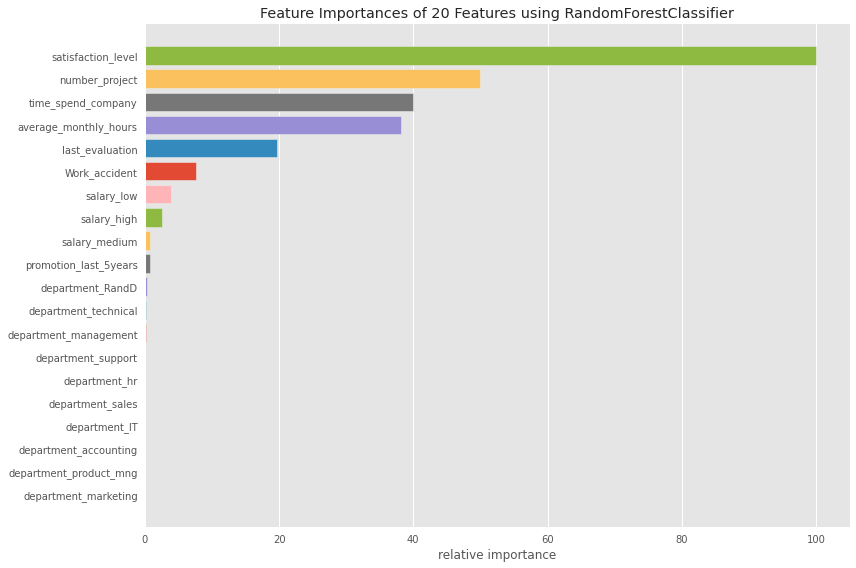

In [ ]:
rf = RandomForestClassifier(bootstrap='True', class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=1, verbose=False,
            warm_start=False)

viz = FeatureImportances(rf)
viz.fit(X_train, y_train)
viz.show();

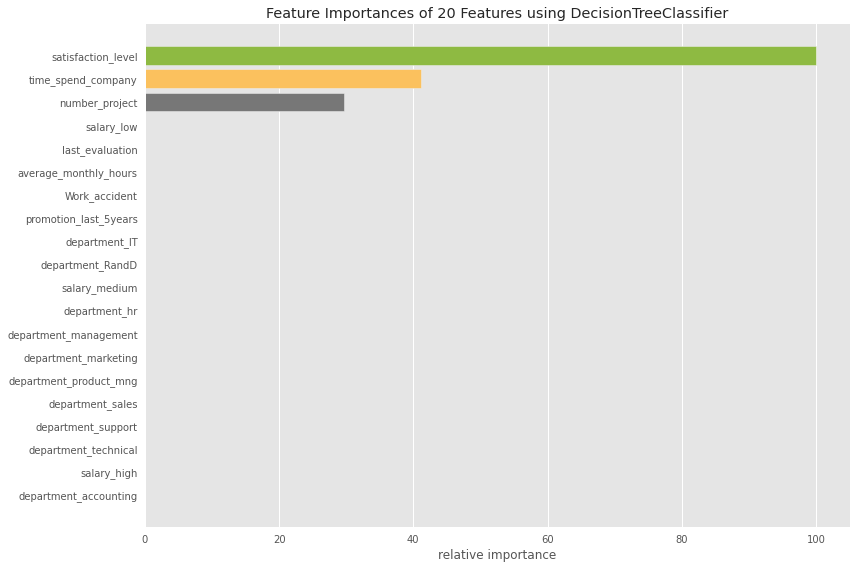

In [ ]:
dt = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

viz = FeatureImportances(dt)
viz.fit(X_train, y_train)
viz.show();

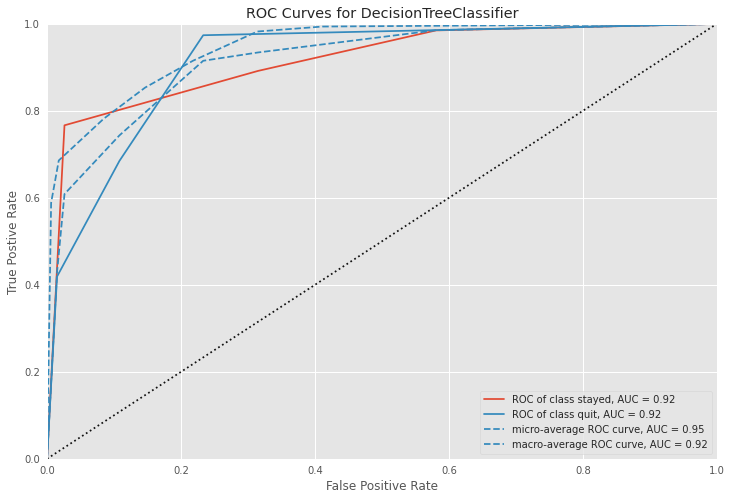

In [ ]:
visualizer = ROCAUC(dt, classes=['stayed', 'quit'])

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

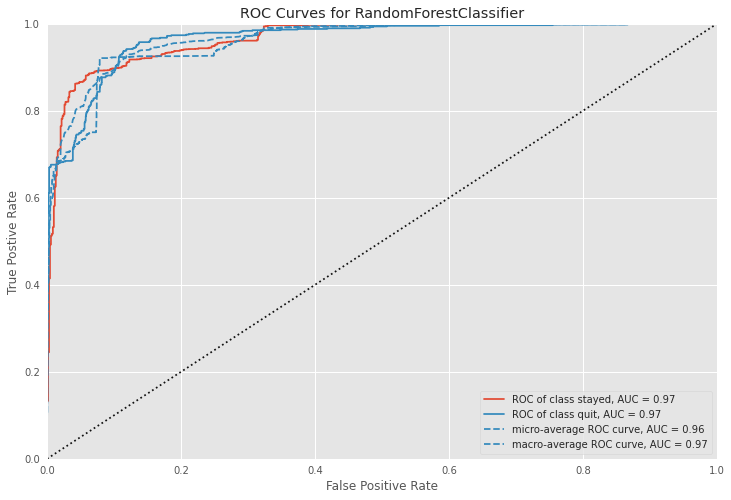

In [ ]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(rf, classes=['stayed', 'quit'])

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof();

Random Forest Classifier is a better model in this case